In [9]:
import pandas as pd
import numpy as np

df = pd.read_csv('table-14.csv')

# drop the file headers
df = df.drop(range(9))

# reassign first row of data frame (df.iloc[0]) to be the column headers
df.columns = df.iloc[0] 

# reset the index column for the dataframe
df = df[1:].reset_index(drop=True) 

# drop unnecessary columns
df = df.drop(columns=['Financial year end', 'Year End Month']) 

# remove any rows where the Value column is NaN
df = df.dropna(subset=['Value (Ratio)']) 

# Negative values are shown in parentheses. Convert these to standard negative
# number notation to avoid errors.
df['Value (Ratio)'] = df['Value (Ratio)'].str.replace('(','-')
df['Value (Ratio)'] = df['Value (Ratio)'].str.replace(')','')

# remove duplicate rows
df = df.drop_duplicates() 

# convert KFI values to number format:

# Identify non-numeric values before coercion
original_values = df['Value (Ratio)']
numeric_values = pd.to_numeric(original_values, errors='coerce')

# Find rows where conversion to numeric failed (became NaN) and the original was not already NaN or an empty string
conversion_errors = df[numeric_values.isna() & original_values.notna() & (original_values != '')]

if not conversion_errors.empty:
    print('The following original entries in "Value (Ratio)" caused conversion errors and will be set to NaN:')
    display(conversion_errors[['KFI ratio title', 'Value (Ratio)']])
else:
    print('No non-numeric conversion errors found in "Value (Ratio)".')

# Convert 'Value (Ratio)' to numeric, coercing errors
df['Value (Ratio)'] = numeric_values 

# Drop rows where 'Value (Ratio)' became NaN after conversion
df.dropna(subset=['Value (Ratio)'], inplace=True) 

df["Value (Ratio)"] = pd.to_numeric(df["Value (Ratio)"], errors='coerce')

# convert % values to decimals for Tableau / other processing

# Create a boolean mask: rows where column KFI ratio title contains '%'
mask = df["KFI ratio title"].astype(str).str.contains("%", na=False) 
df.loc[mask, "Value (Ratio)"] = df.loc[mask, "Value (Ratio)"] / 100 # Divide column Value (Ratio) by 100 only for those rows

display(df.head())

# save the cleaned file without its index
df.to_csv('processed_table-14.csv', index=False) 

print('Cleaned dataframe saved to processed_table-14.csv')

No non-numeric conversion errors found in "Value (Ratio)".


9,UKPRN,HE provider,Country of HE provider,Region of HE provider,Academic Year,KFI ratio title,Value (Ratio)
0,10007783,The University of Aberdeen,Scotland,Scotland,2015/16,Surplus/(deficit) as a % of total income,-0.020
2,10007783,The University of Aberdeen,Scotland,Scotland,2015/16,Staff costs as a % of total income,0.581
4,10007783,The University of Aberdeen,Scotland,Scotland,2015/16,Premises costs as a % of total costs,0.042
6,10007783,The University of Aberdeen,Scotland,Scotland,2015/16,Unrestricted reserves as a % of total income,1.425
7,10007783,The University of Aberdeen,Scotland,Scotland,2015/16,External borrowing as a % of total income,0.313


Cleaned dataframe saved to processed_table-14.csv


In [7]:
import pandas as pd

# Load the processed data
df_processed = pd.read_csv('processed_table-14.csv')

# Pivot the DataFrame, including all other descriptive columns in the index
df_pivot = df_processed.pivot_table(
    index=['UKPRN', 'HE provider', 'Country of HE provider', 'Academic Year','Region of HE provider'],
    columns='KFI ratio title',
    values='Value (Ratio)'
).reset_index()

df_pivot.to_csv('processed_table-14-pivot.csv', index=False) # save the cleaned file without its index

print('Pivoted dataframe saved to processed_table-14-pivot.csv')

Pivoted dataframe saved to processed_table-14-pivot.csv


In [10]:
df_pivot_filtered = df_pivot.filter([
    'UKPRN', 'HE provider', 'Country of HE provider', 'Academic Year',
    'Region of HE provider',
    'Net cash inflow from operating activities as a % of total income',
    'Surplus/(deficit) as a % of total income'
], axis=1)

outlier_col_net_cash = "Net cash inflow from operating activities as a % of total income - Outlier"
outlier_col_surplus  = "Surplus/(deficit) as a % of total income - Outlier"

df_pivot_filtered[outlier_col_net_cash] = False
df_pivot_filtered[outlier_col_surplus]  = False

# --- Outliers for 'Net cash inflow from operating activities as a % of total income' ---
column_net_cash = 'Net cash inflow from operating activities as a % of total income'

s = df_pivot_filtered[column_net_cash]

if not s.dropna().empty:
    upper_threshold_net_cash = np.percentile(s.dropna(), 95)
    lower_threshold_net_cash = np.percentile(s.dropna(), 5)

    # True if BELOW 5th percentile OR ABOVE 95th percentile
    df_pivot_filtered[outlier_col_net_cash] = (s < lower_threshold_net_cash) | (s > upper_threshold_net_cash)
else:
    print(f"Warning: '{column_net_cash}' column is empty or all NaN after initial filtering.")

# Check if DataFrame is empty after the first filter
if df_pivot_filtered.empty:
    print("DataFrame became empty after filtering 'Net cash inflow from operating activities as a % of total income'. No further filtering applied.")
else:
    # --- Filter for 'Surplus/(deficit) as a % of total income' ---
    column_surplus_deficit = 'Surplus/(deficit) as a % of total income'

    s = df_pivot_filtered[column_surplus_deficit]

    # Ensure there's data to calculate percentiles from
    if not s.dropna().empty:
        # Calculate 95th and 5th percentiles from the current state of the DataFrame
        upper_threshold_surplus = np.percentile(s.dropna(), 95)
        lower_threshold_surplus = np.percentile(s.dropna(), 5)

        # Filter the DataFrame to remove values outside these bounds
        df_pivot_filtered[outlier_col_surplus] = (s < lower_threshold_surplus) | (s > upper_threshold_surplus)

    else:
        print(f"Warning: '{column_surplus_deficit}' column is empty or all NaN after previous filtering. Skipping this filter step.")

df_pivot_filtered["Outlying value"] = (df_pivot_filtered["Net cash inflow from operating activities as a % of total income - Outlier"] | df_pivot_filtered["Surplus/(deficit) as a % of total income - Outlier"])


# display(df_pivot_filtered)

df_pivot_filtered.to_csv('processed_table-14-pivot-highlight-outliers.csv', index=False) # save the cleaned file without its index

print('Pivoted dataframe saved to processed_table-14-pivot-highlight-outliers.csv')

Pivoted dataframe saved to processed_table-14-pivot-highlight-outliers.csv


In [ ]:
df_pivot_filtered = df_pivot.filter([
    'UKPRN', 'HE provider', 'Country of HE provider', 'Academic Year',
    'Region of HE provider',
    'Net cash inflow from operating activities as a % of total income',
    'Surplus/(deficit) as a % of total income'
], axis=1)

outlier_col_net_cash = "Net cash inflow from operating activities as a % of total income - Outlier"
outlier_col_surplus  = "Surplus/(deficit) as a % of total income - Outlier"

df_pivot_filtered[outlier_col_net_cash] = False
df_pivot_filtered[outlier_col_surplus]  = False

# --- Outliers for 'Net cash inflow from operating activities as a % of total income' ---
column_net_cash = 'Net cash inflow from operating activities as a % of total income'

s = df_pivot_filtered[column_net_cash]

if not s.dropna().empty:
    upper_threshold_net_cash = np.percentile(s.dropna(), 95)
    lower_threshold_net_cash = np.percentile(s.dropna(), 5)

    # True if BELOW 5th percentile OR ABOVE 95th percentile
    df_pivot_filtered[outlier_col_net_cash] = (s < lower_threshold_net_cash) | (s > upper_threshold_net_cash)
else:
    print(f"Warning: '{column_net_cash}' column is empty or all NaN after initial filtering.")

# Check if DataFrame is empty after the first filter
if df_pivot_filtered.empty:
    print("DataFrame became empty after filtering 'Net cash inflow from operating activities as a % of total income'. No further filtering applied.")
else:
    # --- Filter for 'Surplus/(deficit) as a % of total income' ---
    column_surplus_deficit = 'Surplus/(deficit) as a % of total income'

    s = df_pivot_filtered[column_surplus_deficit]

    # Ensure there's data to calculate percentiles from
    if not s.dropna().empty:
        # Calculate 95th and 5th percentiles from the current state of the DataFrame
        upper_threshold_surplus = np.percentile(s.dropna(), 95)
        lower_threshold_surplus = np.percentile(s.dropna(), 5)

        # Filter the DataFrame to remove values outside these bounds
        df_pivot_filtered[outlier_col_surplus] = (s < lower_threshold_surplus) | (s > upper_threshold_surplus)

    else:
        print(f"Warning: '{column_surplus_deficit}' column is empty or all NaN after previous filtering. Skipping this filter step.")

df_pivot_filtered["Outlying value"] = (df_pivot_filtered["Net cash inflow from operating activities as a % of total income - Outlier"] | df_pivot_filtered["Surplus/(deficit) as a % of total income - Outlier"])


# display(df_pivot_filtered)

df_pivot_filtered.to_csv('processed_table-14-pivot-highlight-outliers.csv', index=False) # save the cleaned file without its index

print('Pivoted dataframe saved to processed_table-14-pivot-highlight-outliers.csv')

Matplotlib is building the font cache; this may take a moment.
C:\Users\ucziesm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


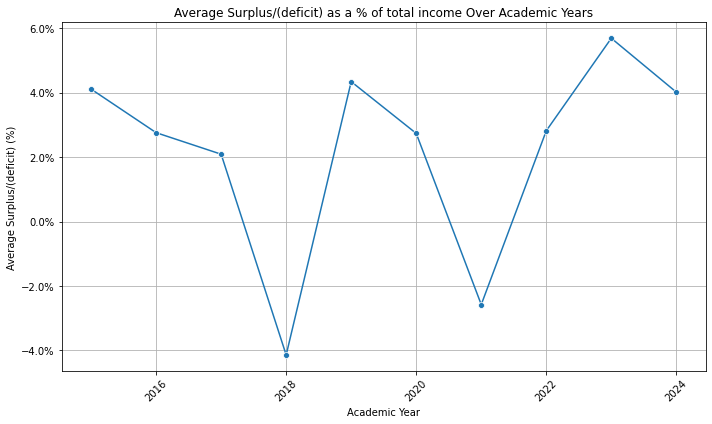

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# filter out outliers
df_excl_outliers = df_pivot_filtered[df_pivot_filtered["Outlying value"] == False]

# Extract the starting year from 'Academic Year' and convert to numeric
# Assuming format like 'YYYY/YY' or 'YYYY-YYYY'
df_excl_outliers['Academic Year'] = df_excl_outliers['Academic Year'].astype(str).str.extract(r'^(\d{4})').astype(float)

# Calculate the mean 'Surplus/(deficit) as a % of total income' per academic year
average_surplus_by_year = df_excl_outliers.groupby('Academic Year')['Surplus/(deficit) as a % of total income'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Academic Year', y='Surplus/(deficit) as a % of total income', data=average_surplus_by_year, marker='o')

# Format y-axis to display as percentages
formatter = mticker.PercentFormatter(xmax=1.0) # Values are already decimals (e.g., 0.05 for 5%)
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Average Surplus/(deficit) as a % of total income Over Academic Years')
plt.xlabel('Academic Year')
plt.ylabel('Average Surplus/(deficit) (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()